# CSCI 250: Project 7 - Lucy Buhayenko

## Importing Libraries

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets, linear_model
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

## Student Lifestyle Dataset

In [137]:
df = pd.read_csv('student_lifestyle_dataset.csv')
df

,Student_ID,Study_Hours_Per_Day,Extracurricular_Hours_Per_Day,Sleep_Hours_Per_Day,Social_Hours_Per_Day,Physical_Activity_Hours_Per_Day,GPA,Stress_Level
0,1,6.9,3.8,8.7,2.8,1.8,2.99,Moderate
1,2,5.3,3.5,8.0,4.2,3.0,2.75,Low
2,3,5.1,3.9,9.2,1.2,4.6,2.67,Low
3,4,6.5,2.1,7.2,1.7,6.5,2.88,Moderate
4,5,8.1,0.6,6.5,2.2,6.6,3.51,High
...,...,...,...,...,...,...,...,...
1995,1996,6.5,0.2,7.4,2.1,7.8,3.32,Moderate
1996,1997,6.3,2.8,8.8,1.5,4.6,2.65,Moderate
1997,1998,6.2,0.0,6.2,0.8,10.8,3.14,Moderate
1998,1999,8.1,0.7,7.6,3.5,4.1,3.04,High


## There are 8 columns

In [138]:
df.columns

Index(['Student_ID', 'Study_Hours_Per_Day', 'Extracurricular_Hours_Per_Day',
       'Sleep_Hours_Per_Day', 'Social_Hours_Per_Day',
       'Physical_Activity_Hours_Per_Day', 'GPA', 'Stress_Level'],
      dtype='object')

## Defining features and target


In [139]:
X = df.drop(columns=["Student_ID", "Stress_Level"])
y = df["Stress_Level"]

## Missing values: There are no missing values, so no need to delete / replace anything

In [140]:
df.isnull().sum()

Student_ID                         0
Study_Hours_Per_Day                0
Extracurricular_Hours_Per_Day      0
Sleep_Hours_Per_Day                0
Social_Hours_Per_Day               0
Physical_Activity_Hours_Per_Day    0
GPA                                0
Stress_Level                       0
dtype: int64

## Splitting Data

In [141]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Part 1

## Compare Decision Tree and Random Forest with different deph with KFold

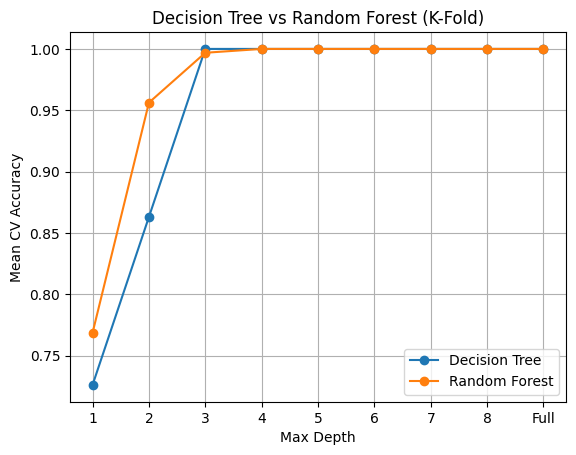

Decision Tree scores = [np.float64(0.72625), np.float64(0.8631249999999999), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0)]
Random Forest scores = [np.float64(0.7687499999999999), np.float64(0.95625), np.float64(0.996875), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0)]


In [142]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)

score_dt = []
score_rf = []
depths = [1, 2, 3, 4, 5, 6, 7, 8, None]

for d in depths:
    dt_scores = []
    rf_scores = []
    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        dt = DecisionTreeClassifier(criterion="gini", max_depth=d, random_state=42)
        rf = RandomForestClassifier(criterion="gini", max_depth=d, n_estimators=100, random_state=42)

        dt.fit(X_tr, y_tr)
        rf.fit(X_tr, y_tr)

        dt_scores.append(dt.score(X_val, y_val))
        rf_scores.append(rf.score(X_val, y_val))

    score_dt.append(np.mean(dt_scores))
    score_rf.append(np.mean(rf_scores))

#results
depth_labels = [str(x) if x is not None else "Full" for x in depths]
plt.plot(depth_labels, score_dt, marker='o', label='Decision Tree')
plt.plot(depth_labels, score_rf, marker='o', label='Random Forest')
plt.xlabel("Max Depth")
plt.ylabel("Mean CV Accuracy")
plt.title("Decision Tree vs Random Forest (K-Fold)")
plt.legend()
plt.grid(True)
plt.show()

print("Decision Tree scores =", score_dt)
print("Random Forest scores =", score_rf)


## Pick the best one

In [143]:
best_dt_depth = depths[np.argmax(score_dt)]
best_rf_depth = depths[np.argmax(score_rf)]

print("Best DT depth:", best_dt_depth, "CV acc:", max(score_dt))
print("Best RF depth:", best_rf_depth, "CV acc:", max(score_rf))

if max(score_rf) >= max(score_dt):
    best_model_type = "RandomForest"
    best_depth = best_rf_depth
else:
    best_model_type = "DecisionTree"
    best_depth = best_dt_depth

print("Best model:", best_model_type, "| Depth:", best_depth)


Best DT depth: 3 CV acc: 1.0
Best RF depth: 4 CV acc: 1.0
Best model: RandomForest | Depth: 4


## Compute the accuracy and  F1 of the testing set

In [144]:
if best_model_type == "RandomForest":
    best_model = RandomForestClassifier(max_depth=best_depth, n_estimators=100, random_state=42)
else:
    best_model = DecisionTreeClassifier(max_depth=best_depth, random_state=42)

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="weighted")

print(f"Test Accuracy: {acc:.3f}")
print(f"Test F1-score: {f1:.3f}")

Test Accuracy: 1.000
Test F1-score: 1.000


## Plotting Confusion Matrix

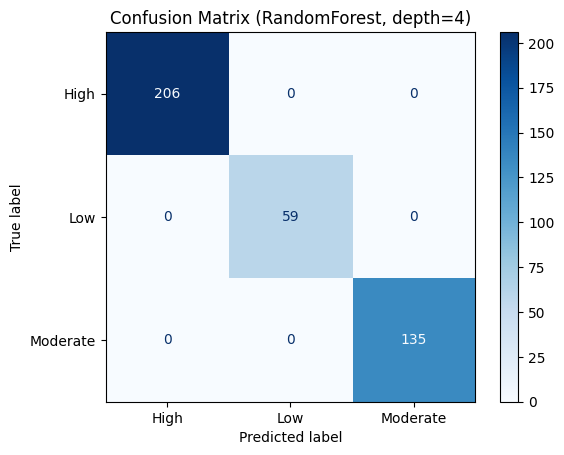

In [145]:
disp = ConfusionMatrixDisplay.from_estimator(
    best_model, X_test, y_test, cmap=plt.cm.Blues
)
disp.ax_.set_title(f"Confusion Matrix ({best_model_type}, depth={best_depth})")
plt.show()

## See what are the most important features, plot an histogram of the features of importance

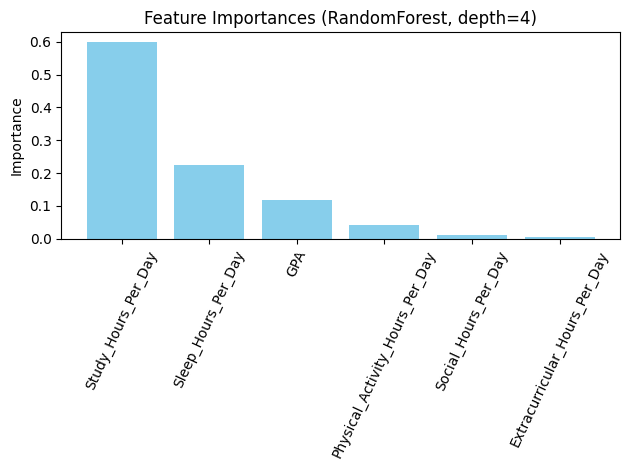

Feature Importances:
Study_Hours_Per_Day                0.598970
Sleep_Hours_Per_Day                0.224530
GPA                                0.117482
Physical_Activity_Hours_Per_Day    0.042458
Social_Hours_Per_Day               0.012517
Extracurricular_Hours_Per_Day      0.004043
dtype: float64


In [146]:
importances = pd.Series(best_model.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

plt.figure()
plt.bar(importances.index, importances.values, color='skyblue')
plt.xticks(rotation=65)
plt.title(f"Feature Importances ({best_model_type}, depth={best_depth})")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

print("Feature Importances:")
print(importances)
